In [13]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})
import matplotlib as mpl
import networkx as nx
import pandas as pd
from scipy.optimize import fsolve

# random graph model
from HydrocarbonSimulationHelpers import phh_from_fit, p3_from_fit

In [5]:
# Summary data
global_data = pd.read_pickle('../../Data/processed_MD/GlobalData.pickle')
skeleton_data = pd.read_pickle('../../Data/processed_MD/SkeletonData.pickle')
# Summary data average between runs
Indices = sorted(list(set([i[:-2] for i in skeleton_data.index])))
global_data_avg = pd.DataFrame(columns=global_data.columns)
skeleton_data_avg = pd.DataFrame(columns=skeleton_data.columns)
def aux_f(x):
    if type(x) == str: return x[:len(x)//2]
    else: return x/2
for idx in Indices:
    if idx == 'CH4_3300K': 
        global_data_avg.loc[idx] = global_data.loc[idx+'_2']
        skeleton_data_avg.loc[idx] = skeleton_data.loc[idx+'_2']
    else:
        skeleton_data_avg.loc[idx] = (skeleton_data.loc[idx+'_1']+skeleton_data.loc[idx+'_2'])/2
        global_data_avg.loc[idx] = (global_data.loc[idx+'_1']+global_data.loc[idx+'_2']).apply(aux_f)

# Arrhenius fits for loop reaction rates

In [6]:
# geometric tail rate decay
def tail_rate(x):
    start,end = 8,15
    xdata = np.arange(start,end+1)
    ydata = x[xdata]
    A = np.vstack([xdata, np.ones_like(xdata)]).T
    m, b = np.linalg.lstsq(A, np.log(ydata), rcond=None)[0]
    return np.exp(m)

C:\Users\HP\AppData\Local\Temp\ipykernel_25384\3574858940.py:7: RuntimeWarning: divide by zero encountered in log
  m, b = np.linalg.lstsq(A, np.log(ydata), rcond=None)[0]


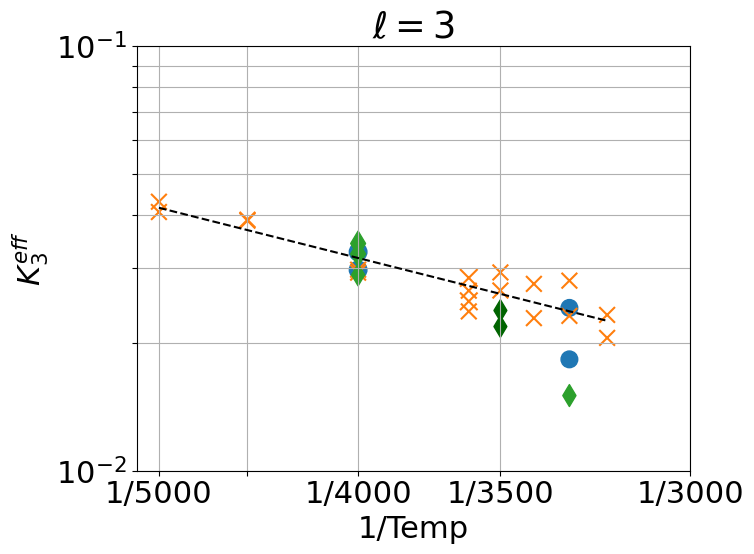

In [11]:
from string import Template

# initializations
Temp = global_data['Temp']
HCR = global_data['Nh']/global_data['Nc']
Nc = global_data['Nc']

# measured params
p3 = global_data['CDegDist'].apply(lambda x: x[3]/(x[3]+x[4]))
# p3 = p3_from_fit(HCR,Temp)
phh = 2*global_data['Nhh']/(2*global_data['Nhh']+global_data['Nch'])
pch = global_data['Nch']/(2*global_data['Ncc']+global_data['Nch'])

rHCH = 3*pch*pch*(2-p3)
r_tail = skeleton_data['LoopSizeDist'].apply(tail_rate)

Vc = (12 + HCR)*Temp

A_vec = []
C_vec = []

phi3 = skeleton_data['LoopSizeDist'].apply(lambda x: x[3]).apply(lambda x: max(x,1e-14))
for L in range(3,10):
    phiL = skeleton_data['LoopSizeDist'].apply(lambda x: x[L]).apply(lambda x: max(x,1e-14))
    phiLm = skeleton_data['LoopSizeDist'].apply(lambda x: x[L-1]).apply(lambda x: max(x,1e-14))
    Lam = skeleton_data['LoopCountDist'].apply(lambda x: x@np.arange(len(x)))/Nc

    # effective reaction rates
    if L == 3:
        Data = Lam*phiL / p3                    # splitting double bond
    elif L == 4 or L == 5:
        Data = Lam*phiL / p3 / p3               # triangle + double bonds
    elif L < 9:
        Data = (phh*HCR*phiL) / (rHCH*phiLm)    # adding a HCH triple to increase loop size
    else:
        Data = r_tail * HCR*phh / rHCH          # geometric tail law

    # training data C4H10, ignore 3200K, 3300K, very noisy
    train_idx = HCR==2.5
    if L > 8: train_idx *= Temp>3300
    xdata = 1/Temp[train_idx].to_numpy(dtype=float)
    ydata = np.log(Data[train_idx].to_numpy(dtype=float))

    # least squares to get Arrhenius fit
    M = np.vstack([xdata, np.ones(len(xdata))]).T
    Cm, logA = np.linalg.lstsq(M, ydata, rcond=None)[0]
    A = np.exp(logA)
    C = -Cm
    A_vec.append(A)
    C_vec.append(C)

    # rescale by e^{c/T} to remove large slope
    fig, ax = plt.subplots(figsize=(8,6))
    

    # plot colored by HCR
    h_vec = [0 for i in range(5)]
    for i,aux in enumerate([(2.25,'o','C0'),(2.5,'x','C1'),(3,'d','C2'),(3.05,'d','darkgreen'),(4,'>','C3')]):
        hcr,marker,color = aux[0],aux[1],aux[2]
        idx = HCR==hcr
        if hcr != 4:
            h_vec[i] = plt.scatter(1/Temp[idx],Data[idx],c=color,s=Nc[idx]/2,alpha=1,marker=marker)
        else: h_vec[i] = plt.scatter(1/5000,0,c=color,s=160/2,alpha=1,marker=marker)
    
    
    # format
    plt.plot([1/5000,1/3200],[A*np.exp(-C/5000),A*np.exp(-C/3200)],'k--')
    plt.yscale('log')
    plt.xticks(ticks=[1/3000,1/3500,1/4000,1/4500,1/5000],labels=["1/3000","1/3500","1/4000","","1/5000"])
    if L < 9: 
        plt.ylabel(Template(r'$$K_${var}^{eff}$$').substitute(var=str(int(L))))
        plt.title(r'$\ell=$'+str(L))
    else: 
        plt.ylabel(r'$K_L$')
        plt.title('Tail rates')
    plt.xlabel('1/Temp')
    plt.grid()
    # scale
    if L == 3:
        plt.ylim([1e-2,1e-1])
        plt.yticks(np.arange(1,11)*.01,[r'$10^{-2}$'] + ['']*8 + [r'$10^{-1}$'])
    elif L == 4:
        plt.ylim([2e-2,4e0])
    elif L == 5:
        plt.ylim([8e-2,1e1])
    else:
        plt.ylim([5e-3,5e-1])
    plt.tight_layout()
    plt.savefig('../../Figures/Loops/ReaxResults/Arrh_' + str(L) + '.pdf')

    if L == 3:
        figlegend,legax = plt.subplots(figsize=(3,3))
        figlegend.legend(h_vec,['HCR=2.25','HCR=2.5','HCR=3','HCR=3.05','HCR=4'])
        legax.axis('off')
        figlegend.tight_layout()
        figlegend.savefig('../../Figures/Loops/ReaxResults/Legend.pdf')
        # figlegend.show()

    plt.close()   

    # plt.show() # shows too many, still shows l=3?
    


Pre-factor A: [0.12389968008853605, 0.00015152476936858752, 6.773381093603916e-05, 4.832975633194731, 5.219656228043643, 4.431445997072439, 4.420962213664369]
exponent C:   [5451.064196288146, -28110.146610953452, -36237.86751560563, 18948.79255231046, 22167.948046709855, 20251.109758230716, 18253.55550832747]


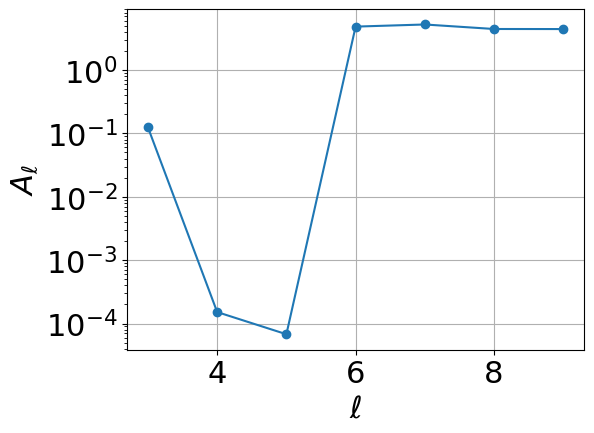

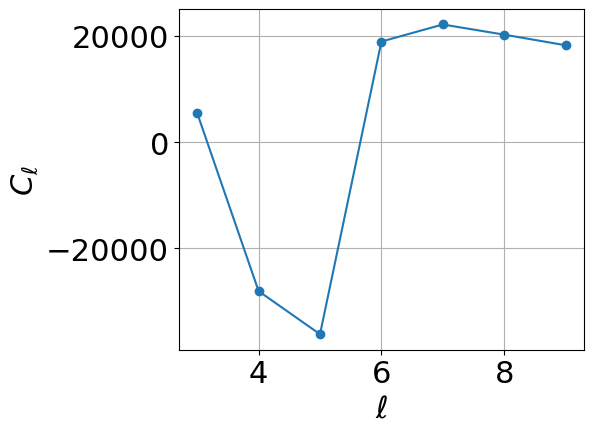

In [12]:
# print Arrhenius coefficients
print('Pre-factor A:',A_vec)
print('exponent C:  ',C_vec)

# plots of reaction rate coefficients - approx. const. for large
plt.plot(range(3,10),A_vec,'o-')
plt.yscale('log')
plt.grid()
plt.xlabel(r'$\ell$')
plt.ylabel(r'$A_\ell$')
plt.tight_layout()
plt.savefig('Temp/A_fit.pdf')
plt.show()



plt.plot(range(3,10),C_vec,'o-')
plt.grid()
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_\ell$')
plt.tight_layout()
plt.savefig('Temp/C_fit.pdf')



def Keff(L,T):
    return A_vec[min(L-3,9-3)]*np.exp(-C_vec[min(L-3,9-3)]/T)

# Error analysis of loop fits

In [30]:
Lam_exp = []
Lam_arrh = []

W1_vec = []
HCR  = global_data_avg['Nh']/global_data_avg['Nc']
Nc   = global_data_avg['Nc']
Temp = global_data_avg['Temp']
Lam  = skeleton_data_avg['LoopCountDist'].apply(lambda x: x@np.arange(len(x)))/Nc

for idx in global_data_avg.index:
    hcr, T = HCR.loc[idx], Temp.loc[idx]
    p3, phh = p3_from_fit(hcr,T), phh_from_fit(hcr,T)
    lam = Lam.loc[idx]
    # measured distribution
    LamPhi_dist_exp = lam*skeleton_data_avg['LoopSizeDist'].loc[idx]
    Lam_exp.append(sum(LamPhi_dist_exp))
    Measured = LamPhi_dist_exp[:-1]/sum(LamPhi_dist_exp[:-1]) # normalize

    Vc = (12+hcr)*T
    kc = 4-p3
    pch = hcr/kc * (1-phh)
    pcc = 1-pch

    rHCH = 3*(2-p3)*pch**2

    # approximate distribution
    LamPhi_dist_arrh = np.zeros_like(Measured)
    LamPhi_dist_arrh[3] = Keff(3,T) * p3
    LamPhi_dist_arrh[4] = Keff(4,T) * p3**2 
    LamPhi_dist_arrh[5] = Keff(5,T) * p3**2 
    for L in range(6,len(LamPhi_dist_arrh)):
        LamPhi_dist_arrh[L] = Keff(L,T) * LamPhi_dist_arrh[L-1]*rHCH / (phh*hcr)
    Lam_arrh.append(sum(LamPhi_dist_arrh))
    Arrhenius = LamPhi_dist_arrh/sum(LamPhi_dist_arrh) # normalize
    
    fig, ax = plt.subplots(1,2,figsize=(12,6))
    ax[0].plot(Measured)
    ax[0].plot(Arrhenius)
    ax[0].set_xlabel('Loop length '+r'$\ell$')
    ax[0].set_yscale('log')
    ax[0].set_title('log scale')
    ax[0].set_ylabel('Fraction of loops of length '+r'$\ell,\ \phi_\ell$')
    ax[1].plot(Measured)
    ax[1].plot(Arrhenius)
    ax[1].set_xlabel('Loop length '+r'$\ell$')
    ax[1].legend(['MD Data','Arrhenius fit'])
    ax[0].grid()
    
    fig.suptitle(idx)
    plt.tight_layout()
    plt.savefig('../../Figures/Loops/ReaxResults/' + idx + '_LoopDist_fit.pdf')
    # plt.show() # too many
    plt.close()

    # compute Wasserstein
    W1_vec.append(sum(abs(np.cumsum(Measured-Arrhenius))))

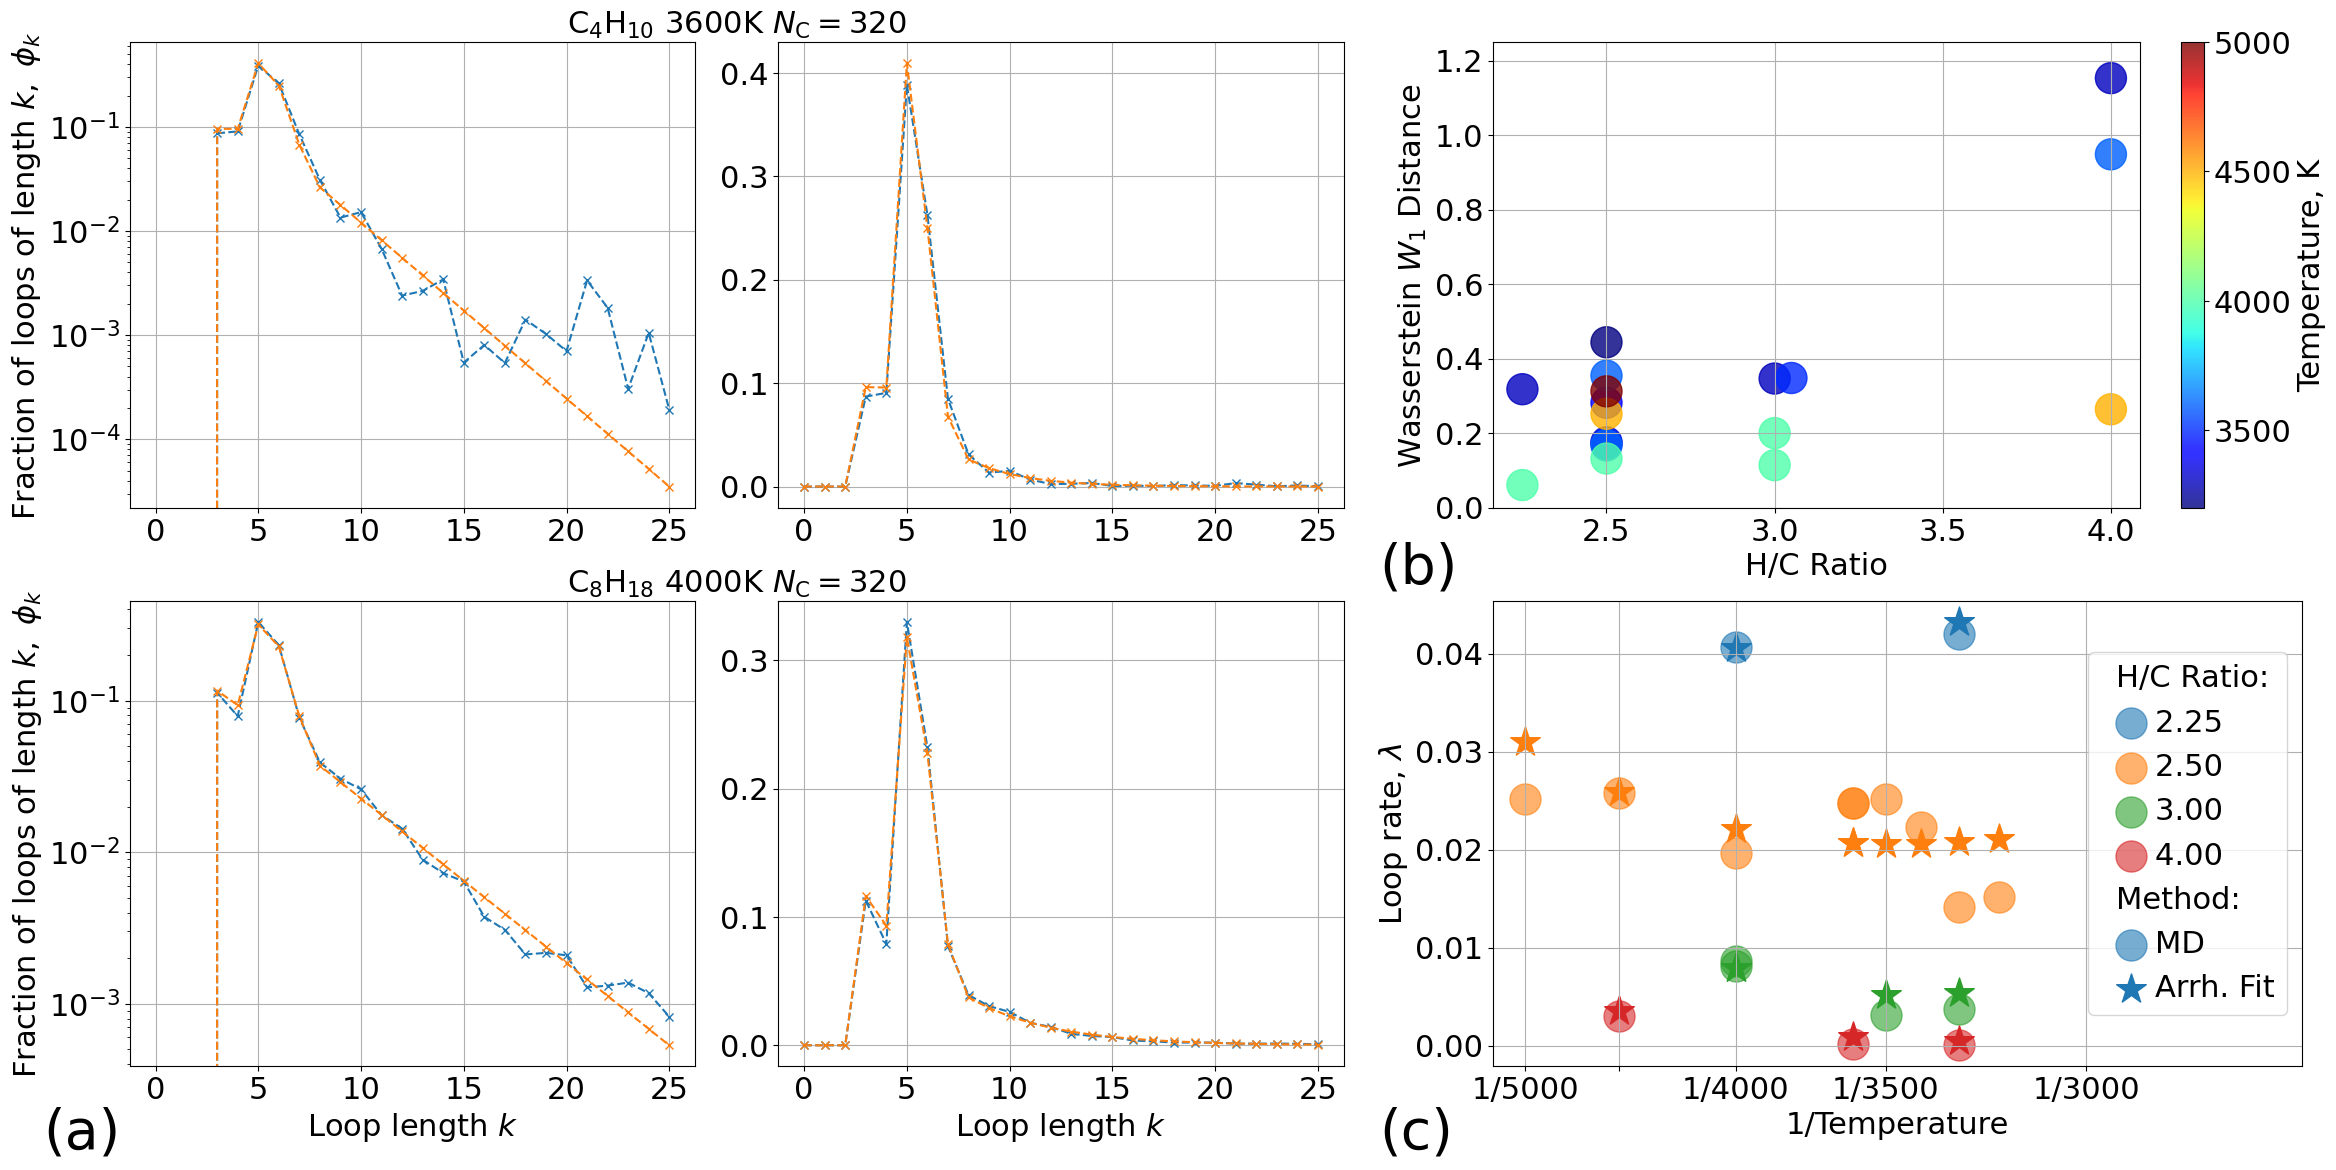

In [61]:
fig= plt.figure(figsize=(24,12))
gs = mpl.gridspec.GridSpec(1,2,figure=fig,width_ratios=[.6,.4])

msize = 500

gs_0 = mpl.gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs[0])
gs_1 = mpl.gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[1])

ax =[[0,0],[0,0]]
tit_ax = [0,0]

for r,item in enumerate([('C4H10_3600K_1120at',r'${\rm C}_4{\rm H}_{10}\ 3600{\rm K}\ N_{\rm C}=320$'),
                        ('C8H18_4000K_1040at',r'${\rm C}_8{\rm H}_{18}\ 4000{\rm K}\ N_{\rm C}=320$')]):
    idx,label = item
    hcr, T = HCR.loc[idx], Temp.loc[idx]
    p3, phh = p3_from_fit(hcr,T), phh_from_fit(hcr,T)
    lam = Lam.loc[idx]
    # measured distribution
    LamPhi_dist_exp = lam*skeleton_data_avg['LoopSizeDist'].loc[idx]
    Measured = LamPhi_dist_exp[:-1]/sum(LamPhi_dist_exp[:-1]) # normalize

    Vc = (12+hcr)*T
    kc = 4-p3
    pch = hcr/kc * (1-phh)
    pcc = 1-pch
    rHCH = 3*(2-p3)*pch**2

    # approximate distribution
    LamPhi_dist_arrh = np.zeros_like(Measured)
    LamPhi_dist_arrh[3] = Keff(3,T) * p3
    LamPhi_dist_arrh[4] = Keff(4,T) * p3**2 
    LamPhi_dist_arrh[5] = Keff(5,T) * p3**2 
    for L in range(6,len(LamPhi_dist_arrh)):
        LamPhi_dist_arrh[L] = Keff(L,T) * LamPhi_dist_arrh[L-1]*rHCH / (phh*hcr)
    Arrhenius = LamPhi_dist_arrh/sum(LamPhi_dist_arrh) # normalize

    ax[r][0] = fig.add_subplot(gs_0[r,0])
    ax[r][0].plot(Measured,'x--')
    ax[r][0].plot(Arrhenius,'x--')
    ax[r][0].grid()
    if r: ax[r][0].set_xlabel(r'Loop length $k$')
    ax[r][0].set_ylabel(r'Fraction of loops of length $k,\ \phi_k$')
    ax[r][0].set_yscale('log')

    
    ax[r][1] = fig.add_subplot(gs_0[r,1])
    ax[r][1].plot(Measured,'x--')
    ax[r][1].plot(Arrhenius,'x--')
    if r: ax[r][1].set_xlabel(r'Loop length $k$')
    ax[r][1].grid()

    tit_ax[r] = fig.add_subplot(gs_0[r,:])
    tit_ax[r].axis('off')
    tit_ax[r].set_title(label,fontsize=22)



# Wasserstein distance
ax_Wass = fig.add_subplot(gs_1[0])
pw = ax_Wass.scatter(HCR,W1_vec,c=global_data_avg['Temp'],cmap='jet',alpha=.8,s=msize)
ax_Wass.set_ylabel('Wasserstein '+r'$W_1$'+' Distance')
ax_Wass.set_xlabel('H/C Ratio')
plt.colorbar(pw,label='Temperature, K',ax=ax_Wass)
ax_Wass.set_ylim([0,1.25])
ax_Wass.grid()

# comparison of loop rates
ax_loopr = fig.add_subplot(gs_1[1])
h = []
for i,hcr in enumerate([2.25,2.5,3,4]):
    idx = np.abs(HCR-hcr)<.1
    # print(Nc[idx])
    h.append(ax_loopr.scatter(1/Temp[idx],np.array(Lam_exp)[idx],marker='o',c='C'+str(i),alpha=.6,s=msize))
    hx = ax_loopr.scatter(1/Temp[idx],np.array(Lam_arrh)[idx],marker='*',c='C'+str(i),s=msize)
    if i == 0: hMD = hx
ax_loopr.set_xticks(ticks=[1/3000,1/3500,1/4000,1/4500,1/5000],labels=["1/3000","1/3500","1/4000","","1/5000"])
ax_loopr.set_xlabel('1/Temperature')
ax_loopr.set_ylabel(r'Loop rate, $\lambda$')
b = ax_loopr.scatter([],[],marker='None')
# h[0],h[5],h[6] = b,b,h[1]
ax_loopr.set_xlim([1/5200,1/2600])
ax_loopr.legend(handles=[b]+h+[b,h[0],hMD],\
            labels=['H/C Ratio:', '    2.25', '    2.50', '    3.00', '    4.00', 'Method:', '    MD', '    Arrh. Fit'],
            ncol=1,handletextpad=-1.5,columnspacing=0.1,loc='center right')
ax_loopr.grid()

plt.tight_layout()

ax[1][1].text(-37,-.08,'(a)',fontsize=40)
ax[1][1].text(28,.36,'(b)',fontsize=40)
ax[1][1].text(28,-.08,'(c)',fontsize=40)
plt.savefig('../../Figures/Loops/ReaxResults/W1Loop+Loopr+LoopDist.pdf')

[0.12389968008853605, 0.00015152476936858725, 6.773381093603916e-05, 4.832975633194727, 5.219656228043643, 4.431445997072439, 4.420962213664369] [5451.064196288146, -28110.14661095346, -36237.86751560563, 18948.792552310457, 22167.948046709855, 20251.109758230716, 18253.55550832747]


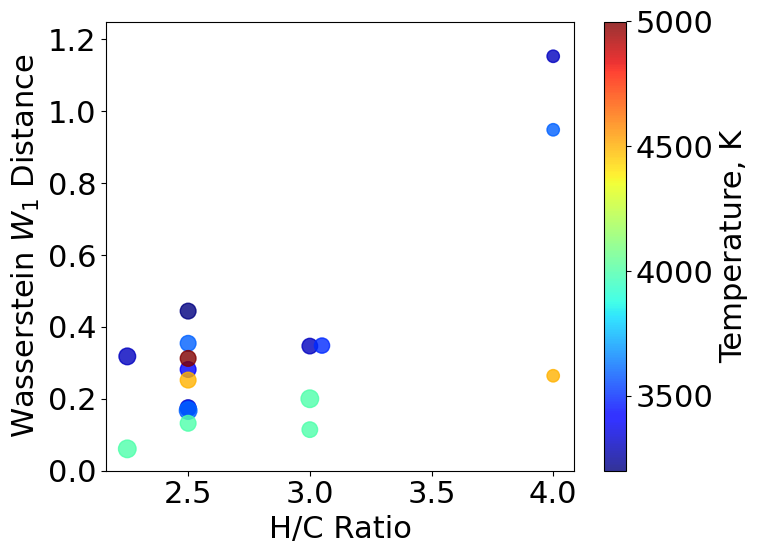

In [10]:
# Wasserstein distance estimated to time-averaged data
plt.subplots(figsize=(8,6))
plt.scatter(HCR,W1_vec,s=global_data_avg['Nc'].to_numpy(float)/2,c=global_data_avg['Temp'],cmap='jet',alpha=.8)
plt.ylabel('Wasserstein '+r'$W_1$'+' Distance')
plt.xlabel('H/C Ratio')
plt.colorbar(label='Temperature, K',)
plt.tight_layout()
plt.ylim([0,1.25])
plt.savefig('../../Figures/Loops/ReaxResults/W1_LoopDist.pdf')
print(A_vec, C_vec)

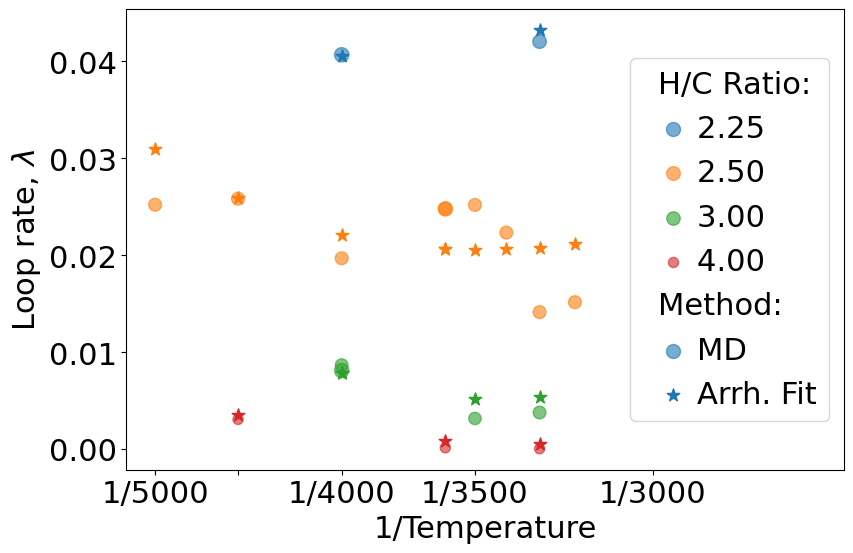

In [11]:
# fit of overall loop rate
plt.subplots(figsize=(9,6))
h = [_ for _ in range(8)]
for i,hcr in enumerate([2.25,2.5,3,4]):
    idx = np.abs(HCR-hcr)<.1
    # print(Nc[idx])
    h[i+1] = plt.scatter(1/Temp[idx],np.array(Lam_exp)[idx],marker='o',c='C'+str(i),alpha=.6,s=Nc[idx].to_numpy(float)/3)
    hMD = plt.scatter(1/Temp[idx],np.array(Lam_arrh)[idx],marker='*',c='C'+str(i),s=90)
    if i == 0: h[-1] = hMD
idx = global_data_avg['Nc']==320

plt.xticks(ticks=[1/3000,1/3500,1/4000,1/4500,1/5000],labels=["1/3000","1/3500","1/4000","","1/5000"])
plt.xlabel('1/Temperature')
plt.ylabel(r'Loop rate, $\lambda$')
b = plt.scatter([],[],marker='None')
h[0],h[5],h[6] = b,b,h[1]
plt.xlim([1/5200,1/2600])
plt.legend(handles=h,labels=['H/C Ratio:', '    2.25', '    2.50', '    3.00', '    4.00', 'Method:', '    MD', '    Arrh. Fit'],
           ncol=1,handletextpad=-1.5,columnspacing=0.1,loc='center right')
plt.tight_layout()
plt.savefig('../../Figures/Loops/ReaxResults/Lam_fit.pdf')